<center>

| Nazwa przedmiotu                          | Dataset                                |
| ----------------------------------------- | -------------------------------------- |
| Projekt zespołowy - sztuczna inteligencja | laptop_prices_dataset                  |
|                                           |                                        |
| Piotr                                     | Goraj                                  |
| Numer albumu                              | 55529                                  |
|                                           |                                        |
| Bartosz                                   | Kiałka                                 |
| Numer albumu                              | 55528                                  |
|                                           |                                        |
| Data oddania sprawozdania                 | 2024.11.16                             |
| Kierunek                                  | Informatyka, II stopnia P, Stacjonarne |

</center>


Nazwa przedmiotu: Projekt zespołowy - sztuczna inteligencja

Kierunek: Informatyka, II stopnia P, Stacjonarne

Dataset: laptop_prices_dataset https://www.kaggle.com/datasets/owm4096/laptop-prices/data



Autorzy:

Piotr Goraj, nr. alb. 55529 (przygotowanie danych oraz predykcja liniowa)

Bartosz Kiałka, nr. alb. 55528 (model klasyfikacji i wartości shapleya)



Data oddania sprawozdania: 2024.11.16

## 1. Instalacja i import bibliotek

In [1]:
# !pip install pandas
# !pip install scikit-learn
# !pip install numpy
# !pip install shap
# !pip install matplotlib
# !pip install seaborn
# !pip install --upgrade shap scikit-learn pandas numpy matplotlib

# !pip install --upgrade shap scikit-learn pandas numpy matplotlib
# !pip install --upgrade shap
# !pip install --upgrade matplotlib seaborn scikit-learn

In [ ]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns

# 2. Odczyt danych

In [3]:
import pandas as pd

# załadowanie pliku CSV
FILE_PATH = './laptop_prices_dataset.csv'
data = pd.read_csv(FILE_PATH)

In [4]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

In [5]:
# pierwsze trzy rekordy
data.head(3)

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620


In [6]:
# podsumowanie statystyczne
print(data.describe())

            Inches          Ram       Weight  Price_euros      ScreenW  \
count  1275.000000  1275.000000  1275.000000  1275.000000  1275.000000   
mean     15.022902     8.440784     2.040525  1134.969059  1900.043922   
std       1.429470     5.097809     0.669196   700.752504   493.346186   
min      10.100000     2.000000     0.690000   174.000000  1366.000000   
25%      14.000000     4.000000     1.500000   609.000000  1920.000000   
50%      15.600000     8.000000     2.040000   989.000000  1920.000000   
75%      15.600000     8.000000     2.310000  1496.500000  1920.000000   
max      18.400000    64.000000     4.700000  6099.000000  3840.000000   

           ScreenH     CPU_freq  PrimaryStorage  SecondaryStorage  
count  1275.000000  1275.000000     1275.000000       1275.000000  
mean   1073.904314     2.302980      444.517647        176.069020  
std     283.883940     0.503846      365.537726        415.960655  
min     768.000000     0.900000        8.000000          0.00

In [7]:
# czy występują wartości null
display(data.isnull().sum())

Company                 0
Product                 0
TypeName                0
Inches                  0
Ram                     0
OS                      0
Weight                  0
Price_euros             0
Screen                  0
ScreenW                 0
ScreenH                 0
Touchscreen             0
IPSpanel                0
RetinaDisplay           0
CPU_company             0
CPU_freq                0
CPU_model               0
PrimaryStorage          0
SecondaryStorage        0
PrimaryStorageType      0
SecondaryStorageType    0
GPU_company             0
GPU_model               0
dtype: int64

In [8]:
# Wybrane kolumny do modeli
selected_columns = [ 'Company','TypeName', 'Price_euros', 'Inches','Ram','OS','Touchscreen','CPU_freq','CPU_model','GPU_company','GPU_model']

# Wczytanie pliku CSV z wybranymi kolumnami
print("Wybrane kolumny CSV:")
df_selected_columns_csv = pd.read_csv(FILE_PATH, usecols=selected_columns)

# pierwsze 10 rekordów
display(df_selected_columns_csv.head(10))

Wybrane kolumny CSV:


,Company,TypeName,Inches,Ram,OS,Price_euros,Touchscreen,CPU_freq,CPU_model,GPU_company,GPU_model
0,Apple,Ultrabook,13.3,8,macOS,1339.69,No,2.3,Core i5,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,8,macOS,898.94,No,1.8,Core i5,Intel,HD Graphics 6000
2,HP,Notebook,15.6,8,No OS,575.00,No,2.5,Core i5 7200U,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,16,macOS,2537.45,No,2.7,Core i7,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,8,macOS,1803.60,No,3.1,Core i5,Intel,Iris Plus Graphics 650
5,Acer,Notebook,15.6,4,Windows 10,400.00,No,3.0,A9-Series 9420,AMD,Radeon R5
6,Apple,Ultrabook,15.4,16,Mac OS X,2139.97,No,2.2,Core i7,Intel,Iris Pro Graphics
7,Apple,Ultrabook,13.3,8,macOS,1158.70,No,1.8,Core i5,Intel,HD Graphics 6000
8,Asus,Ultrabook,14.0,16,Windows 10,1495.00,No,1.8,Core i7 8550U,Nvidia,GeForce MX150
9,Acer,Ultrabook,14.0,8,Windows 10,770.00,No,1.6,Core i5 8250U,Intel,UHD Graphics 620


In [9]:
# Wydzielenie do osobnych plików zbiorów treningowego, walidacyjnego, oraz testowego.

# Podział na zbiór treningowy (70%) oraz zbiór tymczasowy (30% - do podziału na walidacyjny i testowy)
train_data, temp_data = train_test_split(df_selected_columns_csv, test_size=0.3, random_state=42)

# Podział zbioru tymczasowego na walidacyjny (15%) i testowy (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# długość każdego zbioru
prime_len =  len(df_selected_columns_csv)
train_len = len(train_data)
val_len =  len(val_data)
test_len = len(test_data)

print("Długość zbioru:")
print("\tpierwotnego:", prime_len, "(100%)")
print("\ttreningowego:", train_len, "({:.2f}%)".format(train_len * 100 / prime_len))
print("\twalidacyjnego:", val_len, "({:.2f}%)".format(val_len * 100 / prime_len))
print("\ttestowego:", test_len, "({:.2f}%)".format(test_len * 100 / prime_len))

# pierwsze 5 rekordów każdego zbioru
display(train_data.head(5))
display(val_data.head(5))
display(test_data.head(5))

Długość zbioru:
	pierwotnego: 1275 (100%)
	treningowego: 892 (69.96%)
	walidacyjnego: 191 (14.98%)
	testowego: 192 (15.06%)


,Company,TypeName,Inches,Ram,OS,Price_euros,Touchscreen,CPU_freq,CPU_model,GPU_company,GPU_model
314,Asus,2 in 1 Convertible,11.6,2,Windows 10,275.00,Yes,1.1,Celeron Dual Core N3350,Intel,HD Graphics 500
1032,MSI,Gaming,17.3,8,Windows 10,1191.80,No,2.8,Core i7 7700HQ,Nvidia,GeForce GTX 1050
319,Acer,Notebook,11.6,4,Windows 10,485.00,No,1.6,Pentium Quad Core N3710,Intel,HD Graphics 405
1039,HP,Notebook,14.0,8,Windows 10,1010.51,No,2.5,Core i5 7200U,Intel,HD Graphics 620
966,Dell,Notebook,15.6,4,Windows 10,825.00,No,2.5,Core i5 7200U,Intel,HD Graphics 620


,Company,TypeName,Inches,Ram,OS,Price_euros,Touchscreen,CPU_freq,CPU_model,GPU_company,GPU_model
415,Dell,Notebook,15.6,4,Linux,598.9,No,2.5,Core i5 7200U,AMD,Radeon R5 M430
634,Asus,Notebook,15.6,8,Windows 10,399.0,No,1.1,Celeron Dual Core N3350,Intel,HD Graphics 500
1043,Lenovo,Notebook,15.6,8,Windows 10,1049.6,No,2.3,Core i5 6200U,Intel,HD Graphics 520
63,Asus,Notebook,14.0,8,Windows 10,941.0,No,1.6,Core i5 8250U,Intel,UHD Graphics 620
96,Dell,Notebook,15.6,8,Linux,599.9,No,2.7,Core i7 7500U,AMD,Radeon R5 M430


,Company,TypeName,Inches,Ram,OS,Price_euros,Touchscreen,CPU_freq,CPU_model,GPU_company,GPU_model
1050,Lenovo,Notebook,14.0,16,Windows 7,2620.00,No,2.6,Core i7 6600U,Intel,HD Graphics 520
701,Lenovo,Notebook,15.6,4,Windows 10,399.00,No,2.9,A9-Series 9420,AMD,Radeon 530
628,Asus,2 in 1 Convertible,13.3,6,Windows 10,639.01,Yes,2.5,Core i5 7200U,Intel,HD Graphics 620
467,Dell,Notebook,15.6,8,Windows 10,759.00,No,1.6,Core i5 8250U,AMD,Radeon 530
1006,HP,Notebook,14.0,4,Windows 10,1205.00,No,2.5,Core i5 7200U,Intel,HD Graphics 620


# 3. Przygotowanie danych do modelu

In [10]:
def replace_with_top_n(data: DataFrame, column: str, n: int, other_label: str ="Other"):
    """
    Zamienia wartości w kolumnie na n najczęściej występujących,
    a pozostałe wartości na 'Other'.
    
    Params:
    - column: Nazwa kolumny do przetworzenia.
    - n: Liczba najczęściej występujących wartości, które mają zostać zachowane.
    - other_label: Etykieta dla pozostałych wartości (domyślnie "Other").

    Returns:
    - DataFrame z przekształconą kolumną.
    """
    top_n = data[column].value_counts().nlargest(n).index
    data[column] = data[column].apply(lambda x: x if x in top_n else other_label)

def replace_with_log_transformation(data: DataFrame, column: str):
    """
    Zamienia wartości w kolumnie na wartości zlogarytmowane.

    Params:
    - column: Nazwa kolumny do przetworzenia.
    """
    data[column] = np.log1p(data[column])

def remove_model_number(data: DataFrame, column: str):
    """
    Usuwa końcowe cyfry (model) z nazwy, pozostawiając tylko część tekstową.
    
    Params:
    - text (str): Tekst do przetworzenia (np. "Core i5 7200U").
    
    Returns:
    - str: Przetworzony tekst bez końcowych cyfr (np. "Core i5").
    """
    data[column] = data[column].apply(lambda text: re.sub(r'\s+\d+\w*$', '', text))

def encode_with_dummies(data: DataFrame, columns: list):
    """
    Przekształca wybrane kolumny na zmienne zero-jedynkowe (one-hot encoding).
    
    Params:
    - data: DataFrame do przekształcenia.
    - columns: Lista kolumn kategorycznych do zakodowania.
    
    Returns:
    - DataFrame z zakodowanymi kolumnami.
    """
    data_encoded = pd.get_dummies(data, columns=columns, drop_first=True)  
    # drop_first zapobiega pułapce zmiennych fikcyjnych 
    # Usuwa pierwszą kolumnę dla każdej kategorii, 
    # aby uniknąć pułapki zmiennych fikcyjnych (tzw. dummy variable trap). 
    # Pomaga to w modelach regresji uniknąć współliniowości.
    return data_encoded


#### 3.1 Dane treningowe

In [11]:
# top 5 Company
replace_with_top_n(train_data, 'Company', 5)
replace_with_top_n(val_data, 'Company', 5)
replace_with_top_n(test_data, 'Company', 5)

# top 3 TypeName
replace_with_top_n(train_data, 'TypeName', 3)
replace_with_top_n(val_data, 'TypeName', 3)
replace_with_top_n(test_data, 'TypeName', 3)

# top 4 OS
replace_with_top_n(train_data, 'OS', 4)
replace_with_top_n(val_data, 'OS', 4)
replace_with_top_n(test_data, 'OS', 4)

# Top 5 CPU_model
remove_model_number(train_data, 'CPU_model')
remove_model_number(val_data, 'CPU_model')
remove_model_number(test_data, 'CPU_model')

replace_with_top_n(train_data, 'CPU_model', 5)
replace_with_top_n(val_data, 'CPU_model', 5)
replace_with_top_n(test_data, 'CPU_model', 5)

# Top 5 GPU_company
replace_with_top_n(train_data, 'GPU_company', 5)
replace_with_top_n(val_data, 'GPU_company', 5)
replace_with_top_n(test_data, 'GPU_company', 5)

# Top 5 GPU_model
remove_model_number(train_data, 'GPU_model')
remove_model_number(val_data, 'GPU_model')
remove_model_number(test_data, 'GPU_model')

replace_with_top_n(train_data, 'GPU_model', 5)
replace_with_top_n(val_data, 'GPU_model', 5)
replace_with_top_n(test_data, 'GPU_model', 5)

"""
"""

# Transformacja logarytmiczna Ram
replace_with_log_transformation(train_data, 'Ram')
replace_with_log_transformation(val_data, 'Ram')
replace_with_log_transformation(test_data, 'Ram')

# Transformacja logarytmiczna Price_euros
replace_with_log_transformation(train_data, 'Price_euros')
replace_with_log_transformation(val_data, 'Price_euros')
replace_with_log_transformation(test_data, 'Price_euros')

# Transformacja logarytmiczna Inches
replace_with_log_transformation(train_data, 'Inches')
replace_with_log_transformation(val_data, 'Inches')
replace_with_log_transformation(test_data, 'Inches')

# Transformacja logarytmiczna CPU_freq
replace_with_log_transformation(train_data, 'CPU_freq')
replace_with_log_transformation(val_data, 'CPU_freq')
replace_with_log_transformation(test_data, 'CPU_freq')

"""
"""

# One-hot encoding
columns_to_encode = ['OS', 'GPU_company']

train_data_dummies = encode_with_dummies(train_data, columns_to_encode)
val_data_dummies = encode_with_dummies(val_data, columns_to_encode)
test_data_dummies = encode_with_dummies(test_data, columns_to_encode)


# 4. Enkodowanie wartości kategorycznych

In [12]:
def encode_categorical_columns(data: pd.DataFrame):
    """
    Koduje kolumny kategoryczne na numeryczne za pomocą kodowania etykiet (Label Encoding).
    
    Params:
    - data: DataFrame, w którym kolumny kategoryczne mają zostać zakodowane.
    
    Returns:
    - DataFrame z zakodowanymi kolumnami oraz słownik zawierający LabelEncodery dla każdej kolumny.
    """
    data_encoded = data.copy()
    label_encoders = {}
    
    for col in data_encoded.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        data_encoded[col] = le.fit_transform(data_encoded[col])
        label_encoders[col] = le 
    
    return data_encoded, label_encoders

In [13]:
# Ujednolicenie cech po 'get_dummies'
def align_columns(train, val, test):
    all_columns = train.columns
    
    # Dodanie brakujących kolumn w walidacyjnym i testowym
    for df in [val, test]:
        missing_cols = set(all_columns) - set(df.columns)
        for col in missing_cols:
            df[col] = 0  # Dodanie brakujących kolumn z wartościami 0
        
        df = df[all_columns]  # Sortowanie kolumn zgodnie z kolejnością w danych treningowych
    return train, val, test

# Stosowanie funkcji po utworzeniu danych 'dummies'
train_data_dummies, val_data_dummies, test_data_dummies = align_columns(train_data_dummies, val_data_dummies, test_data_dummies)


In [14]:
train_data_encoded = train_data_dummies.copy()
val_data_encoded = val_data_dummies.copy()
test_data_encoded = test_data_dummies.copy()

train_data_encoded, train_label_encoders = encode_categorical_columns(train_data_dummies)
val_data_encoded, val_label_encoders = encode_categorical_columns(val_data_dummies)
test_data_encoded, test_label_encoders = encode_categorical_columns(test_data_dummies)

# Wyświetlenie pierwszych 20 rekordów ze zbioru treningowego po kodowaniu
display(train_data_encoded.head(20))


,Company,TypeName,Inches,Ram,Price_euros,Touchscreen,CPU_freq,CPU_model,GPU_model,OS_No OS,OS_Other,OS_Windows 10,OS_Windows 7,GPU_company_ARM,GPU_company_Intel,GPU_company_Nvidia
314,1,2,2.533697,1.098612,5.620401,1,0.741937,1,2,False,False,True,False,False,True,False
1032,5,0,2.906901,2.197225,7.084059,0,1.335001,4,1,False,False,True,False,False,False,True
319,0,1,2.533697,1.609438,6.186209,0,0.955511,5,2,False,False,True,False,False,True,False
1039,3,1,2.708050,2.197225,6.919200,0,1.252763,3,2,False,False,True,False,False,True,False
966,2,1,2.809403,1.609438,6.716595,0,1.252763,3,2,False,False,True,False,False,True,False
5,0,1,2.809403,1.609438,5.993961,0,1.386294,5,3,False,False,True,False,False,False,False
100,3,1,2.809403,2.197225,6.579251,0,1.308333,4,4,False,False,True,False,False,False,False
713,1,1,2.708050,1.609438,5.700444,0,0.741937,1,2,False,False,True,False,False,True,False
570,3,2,2.906901,2.197225,7.529401,0,1.335001,3,3,False,False,True,False,False,False,True
548,3,1,2.809403,1.609438,5.986452,0,1.098612,2,2,False,False,True,False,False,True,False


# 5. Zapis przygotowanych danych do pliku

In [15]:
train_data_encoded.to_csv('train_data.csv', index=False)
val_data_encoded.to_csv('val_data.csv', index=False)
test_data_encoded.to_csv('test_data.csv', index=False)

# 6. Odczyt danych do modelu

In [16]:
TRAIN_FILE_PATH = './train_data.csv'
VAL_FILE_PATH = './val_data.csv'
TEST_FILE_PATH = './test_data.csv'

train_model_data = pd.read_csv(TRAIN_FILE_PATH)
val_model_data = pd.read_csv(VAL_FILE_PATH)
test_model_data = pd.read_csv(TEST_FILE_PATH)

# 7. Model predykcyjny - Regresja

#### Kluczowe pojęcia:

  - Hiperparametry: Są to parametry, które musisz ustawić przed rozpoczęciem treningu modelu (np. wartość współczynnika regularizacji w Lasso). Różnią się od parametrów modelu, które są wyznaczane podczas treningu (np. współczynniki w regresji liniowej).

  - Grid Search/Random Search: Techniki przeszukiwania przestrzeni hiperparametrów w celu znalezienia najlepszych ustawień. Grid Search testuje wszystkie kombinacje, a Random Search losowo wybiera kombinacje.

  - Skalowanie danych (MinMaxScaler): Przekształca dane tak, aby mieściły się w określonym przedziale (zwykle od 0 do 1). Jest to ważne, ponieważ wiele algorytmów (w tym regresja) działa lepiej, gdy cechy są na tej samej skali.

In [17]:
# podział na cechy (X) oraz etykiety (y)
X_train = train_model_data.drop(columns=['Price_euros'])  
y_train = train_model_data['Price_euros']

X_val = val_model_data.drop(columns=['Price_euros'])
y_val = val_model_data['Price_euros']

X_test = test_model_data.drop(columns=['Price_euros'])
y_test = test_model_data['Price_euros']

# połączenie zbioru treningowego i walidacyjnego
X_train_combined = pd.concat([X_train, X_val], axis=0)
y_train_combined = pd.concat([y_train, y_val], axis=0)

# ujednolicenie kolumn i ich kolejności
def align_and_sort_columns(train, test):
    all_columns = train.columns.tolist()
    for col in all_columns:
        if col not in test.columns:
            test[col] = 0
    return train, test[all_columns]

X_train_combined, X_test = align_and_sort_columns(X_train_combined, X_test)

# skalowanie danych
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test) # Użycie fit_transform tylko na danych treningowych

In [18]:
# regresja liniowa i Lasso
linear_model = LinearRegression()
lasso_model = Lasso()

In [19]:
''' 
  Hiperparametry to parametry, które są ustawiane przed rozpoczęciem treningu modelu 
  i kontrolują jego działanie oraz sposób uczenia się. Dobór hiperparametrów wpływa 
  na jakość i wydajność modelu.
'''
# optymalizacja hiperparametrów dla Lasso
## Hiperparametr alpha kontroluje siłę regularizacji - małe wartości oznaczają słabszą regularyzacje,
## mogą prowadzić do overfittingu (nadmiernego dopasowania). Duże wartości natomiast mogą prowadzić do
## uderfittingu.
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search_lasso.fit(X_train_scaled, y_train_combined)

random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_grid, n_iter=5, 
                                         cv=5, scoring='r2', random_state=42)
random_search_lasso.fit(X_train_scaled, y_train_combined)

# najlepszy model Lasso
## best_estimator_ - to atrybut GridSearchCV, który przechowuje najlepszy model 
## (czyli ten, który osiągnął najwyższy wynik dla wybranej metryki)
best_lasso_model_grid = grid_search_lasso.best_estimator_
best_lasso_model_random = random_search_lasso.best_estimator_

In [20]:
# trenowanie modeli
linear_model.fit(X_train_scaled, y_train_combined)
best_lasso_model_grid.fit(X_train_scaled, y_train_combined)
best_lasso_model_random.fit(X_train_scaled, y_train_combined)

# predykcje
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_lasso_grid = best_lasso_model_grid.predict(X_test_scaled)
y_pred_lasso_random = best_lasso_model_random.predict(X_test_scaled)

In [21]:
# ocena modeli
def evaluate_model(y_true, y_pred, model_name):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Wyniki dla {model_name}:")
    print(f"Średnia rzeczywista: {mean_true:.4f}")
    print(f"Średnia przewidywana: {mean_pred:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print("-" * 30)

evaluate_model(y_test, y_pred_linear, "Regresja Liniowa")
evaluate_model(y_test, y_pred_lasso_grid, "Lasso - GridSearch")
evaluate_model(y_test, y_pred_lasso_random, "Lasso - RandomSearch")

Wyniki dla Regresja Liniowa:
Średnia rzeczywista: 6.8673
Średnia przewidywana: 6.8553
R2: 0.7117
RMSE: 0.3243
MAE: 0.2544
------------------------------
Wyniki dla Lasso - GridSearch:
Średnia rzeczywista: 6.8673
Średnia przewidywana: 6.8444
R2: 0.6638
RMSE: 0.3502
MAE: 0.2893
------------------------------
Wyniki dla Lasso - RandomSearch:
Średnia rzeczywista: 6.8673
Średnia przewidywana: 6.8444
R2: 0.6638
RMSE: 0.3502
MAE: 0.2893
------------------------------


In [ ]:
'''
  Średnia rzeczywista oraz przewidywana - jeżali różnica między średnią 
  rzeczywistą a przewidywaną jest mała model dobrze odtwarza ogólną tendencję danych.

  R^2 - Współczynnik determinacji. Określa jaka część wariancji zmiennej zależnej 
    jest wyjaśniana przez model. Przyjmuje wartości ujemne (jeśli model jest bardzo słaby) 
    do 1 (wtedy model jest przeuczony)

  RMSE - Root Mean Squared Error - to pierwiastek kwadratowy średniej błędów kwadratowych 
    między rzeczywistymi a przewidywanymi wartościami. Im wartość RMSE jest mniejsza tym lepiej.
  
  MAE - Mean Absolute Error -  oblicza średnią z wartości bezwzględnych różnic między 
    przewidywanymi a rzeczywistymi wartościami. Im wartość niższa tym lepszy model.
'''

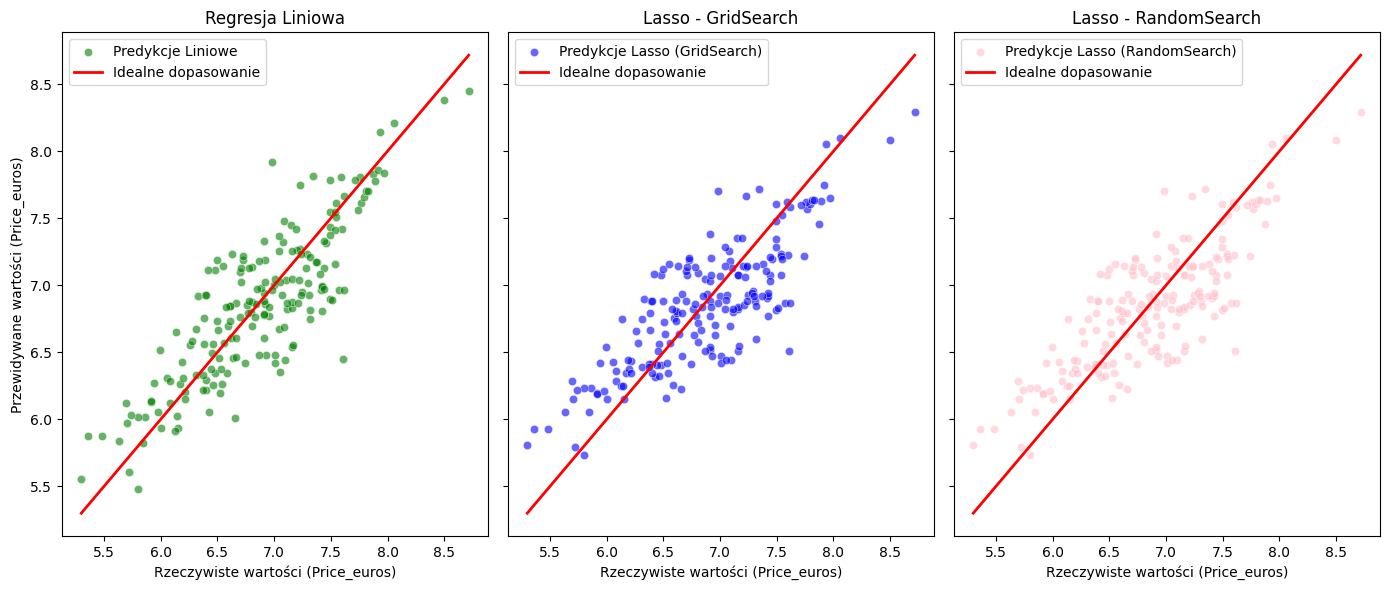

In [23]:
# wykresy predykcji vs idealnych dopasowań 
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True) 

# wykres dla regresji liniowej
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.6, color='green', label='Predykcje Liniowe', ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[0].set_title("Regresja Liniowa")
axes[0].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[0].set_ylabel("Przewidywane wartości (Price_euros)")
axes[0].legend()

# wykresy dla modeli Lasso
sns.scatterplot(x=y_test, y=y_pred_lasso_grid, alpha=0.6, color='blue', label='Predykcje Lasso (GridSearch)', ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[1].set_title("Lasso - GridSearch")
axes[1].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[1].legend()

sns.scatterplot(x=y_test, y=y_pred_lasso_random, alpha=0.6, color='pink', label='Predykcje Lasso (RandomSearch)', ax=axes[2])
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[2].set_title("Lasso - RandomSearch")
axes[2].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[2].legend()

plt.tight_layout()
plt.show()

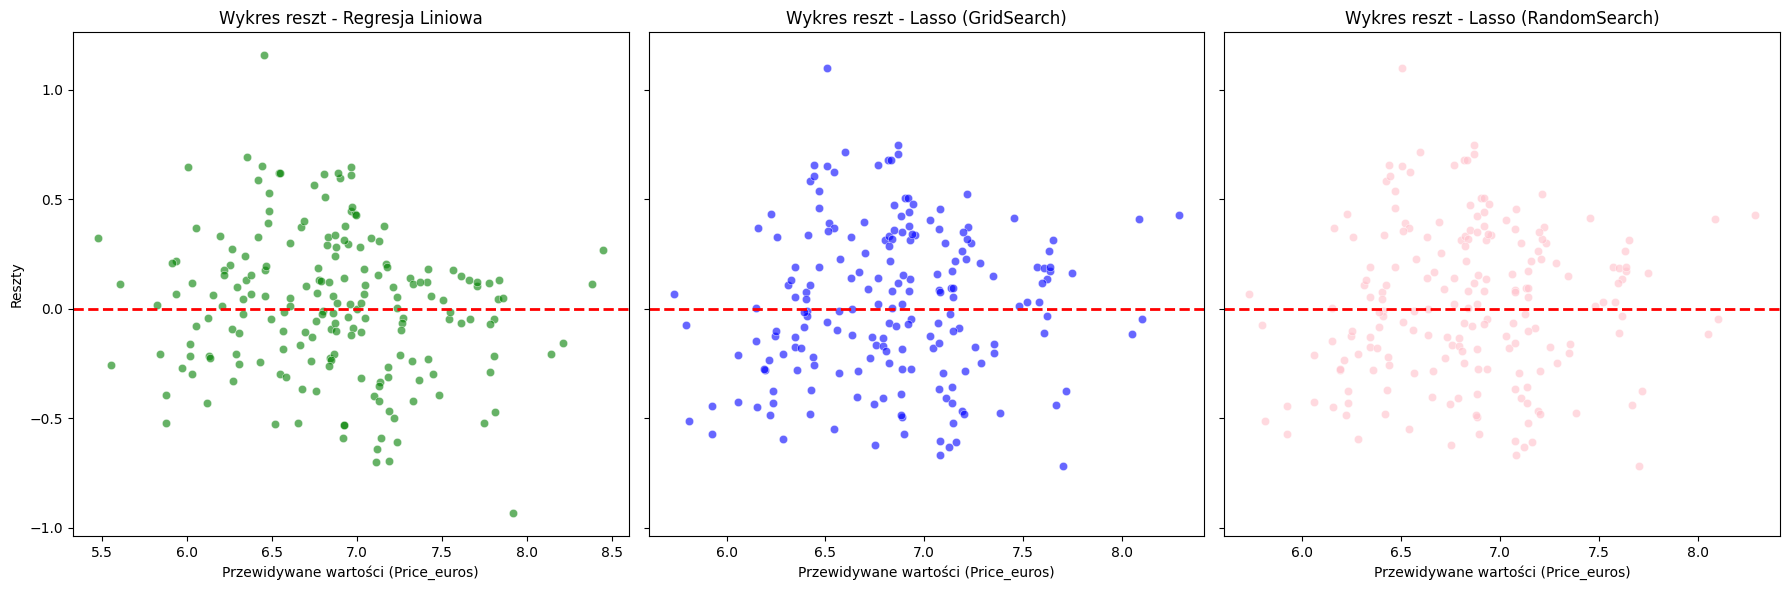

In [24]:
# reszty dla każdego modelu
residuals_linear = y_test - y_pred_linear
residuals_lasso_grid = y_test - y_pred_lasso_grid
residuals_lasso_random = y_test - y_pred_lasso_random

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# wykres dla regresji liniowej
sns.scatterplot(x=y_pred_linear, y=residuals_linear, alpha=0.6, color='green', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', lw=2)
axes[0].set_title("Wykres reszt - Regresja Liniowa")
axes[0].set_xlabel("Przewidywane wartości (Price_euros)")
axes[0].set_ylabel("Reszty")

# wykres dla Lasso (GridSearch)
sns.scatterplot(x=y_pred_lasso_grid, y=residuals_lasso_grid, alpha=0.6, color='blue', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_title("Wykres reszt - Lasso (GridSearch)")
axes[1].set_xlabel("Przewidywane wartości (Price_euros)")

# wykres dla Lasso (RandomSearch)
sns.scatterplot(x=y_pred_lasso_random, y=residuals_lasso_random, alpha=0.6, color='pink', ax=axes[2])
axes[2].axhline(0, color='red', linestyle='--', lw=2)
axes[2].set_title("Wykres reszt - Lasso (RandomSearch)")
axes[2].set_xlabel("Przewidywane wartości (Price_euros)")

plt.tight_layout()
plt.show()


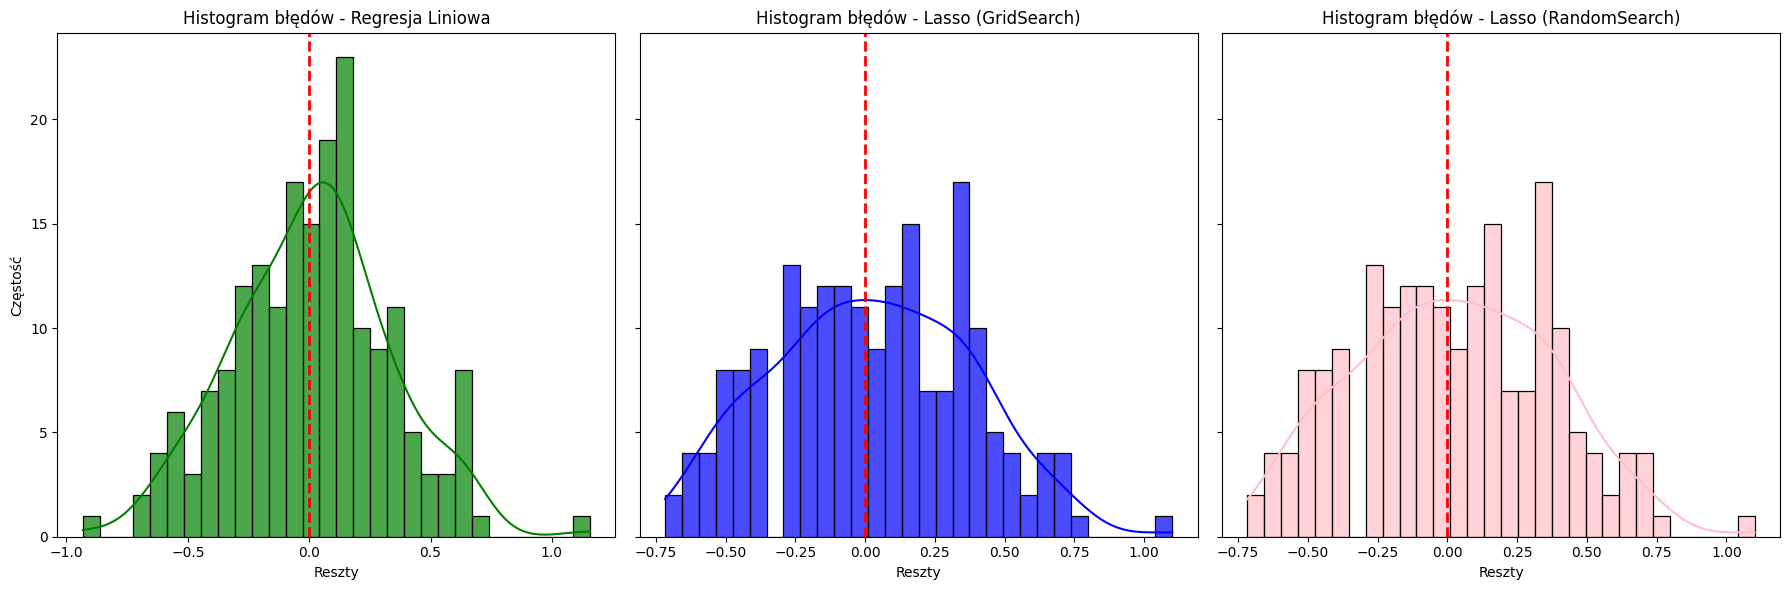

In [25]:
# wykresy histogramów błędów
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# histogram dla regresji liniowej
sns.histplot(residuals_linear, kde=True, bins=30, color='green', alpha=0.7, ax=axes[0])
axes[0].axvline(0, color='red', linestyle='--', lw=2)
axes[0].set_title("Histogram błędów - Regresja Liniowa")
axes[0].set_xlabel("Reszty")
axes[0].set_ylabel("Częstość")

# histogram dla Lasso (GridSearch)
sns.histplot(residuals_lasso_grid, kde=True, bins=30, color='blue', alpha=0.7, ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_title("Histogram błędów - Lasso (GridSearch)")
axes[1].set_xlabel("Reszty")

# histogram dla Lasso (RandomSearch)
sns.histplot(residuals_lasso_random, kde=True, bins=30, color='pink', alpha=0.7, ax=axes[2])
axes[2].axvline(0, color='red', linestyle='--', lw=2)
axes[2].set_title("Histogram błędów - Lasso (RandomSearch)")
axes[2].set_xlabel("Reszty")

plt.tight_layout()
plt.show()


# 8. Wykres Sumaryczny Wartości SHAP


Wynik R² na zbiorze walidacyjnym: 0.7476350255322721


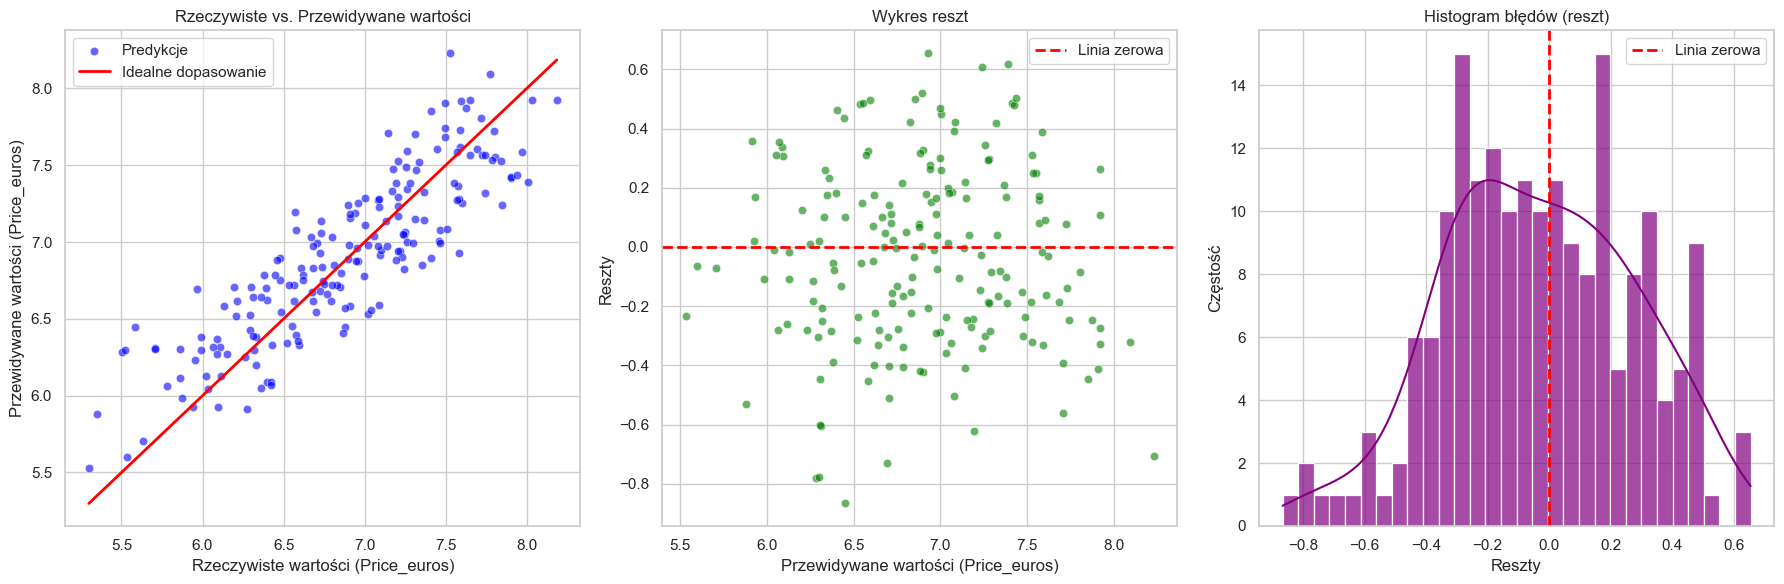


Najważniejsze cechy wpływające na cenę:
               Feature  Coefficient
3                  Ram     0.346928
14  GPU_company_Nvidia     0.190164
5             CPU_freq     0.141547
1             TypeName     0.134352
13   GPU_company_Intel     0.104517
11        OS_Windows 7     0.093249
0              Company     0.068324
7            GPU_model     0.058111
8             OS_No OS    -0.056071
10       OS_Windows 10     0.050406


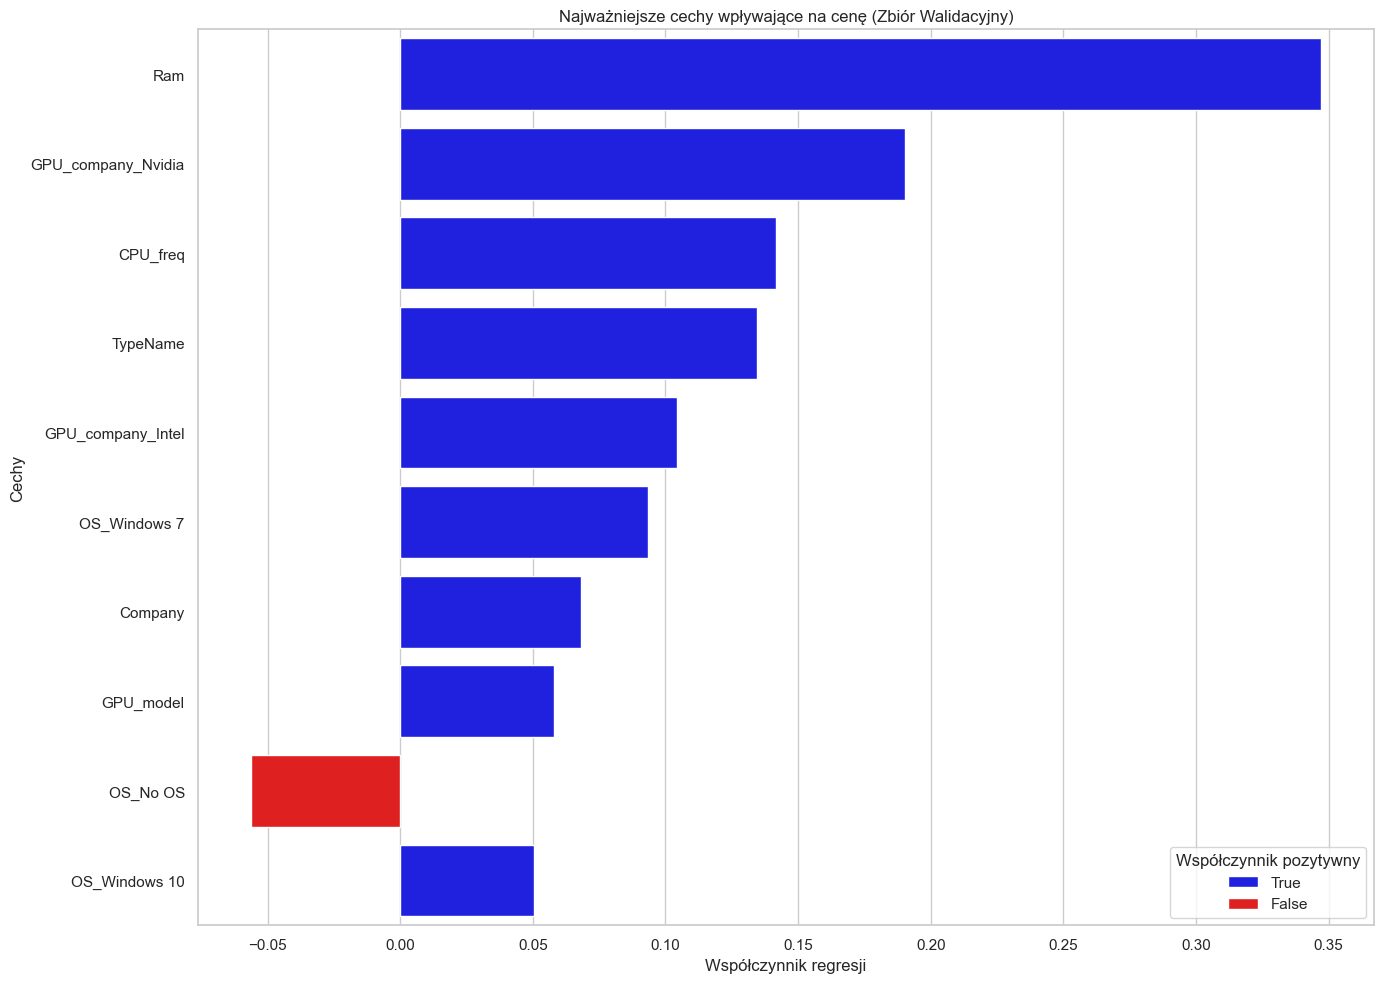

<Figure size 1400x1000 with 0 Axes>

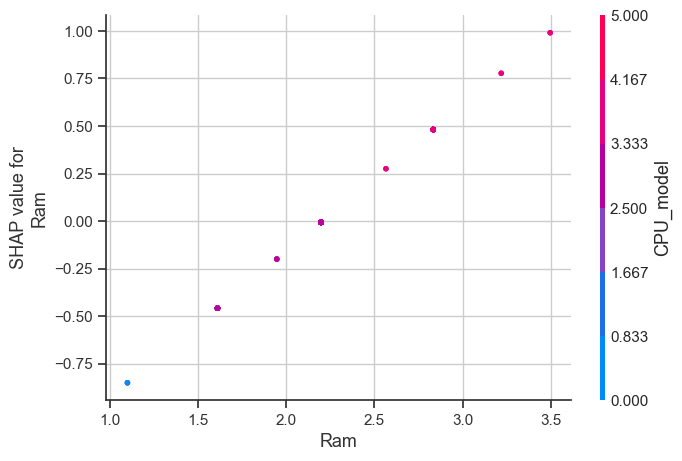

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

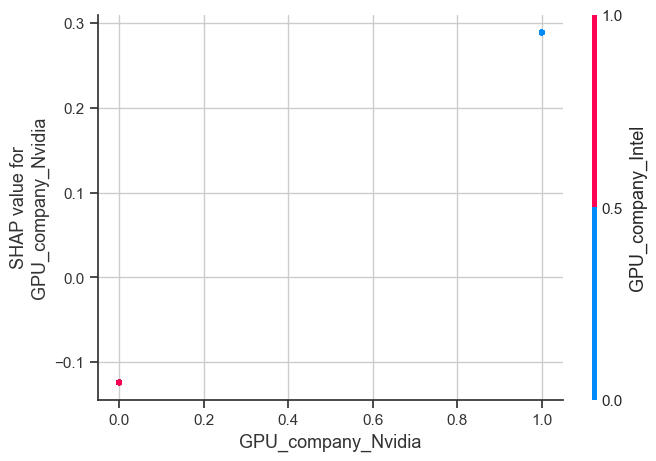

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

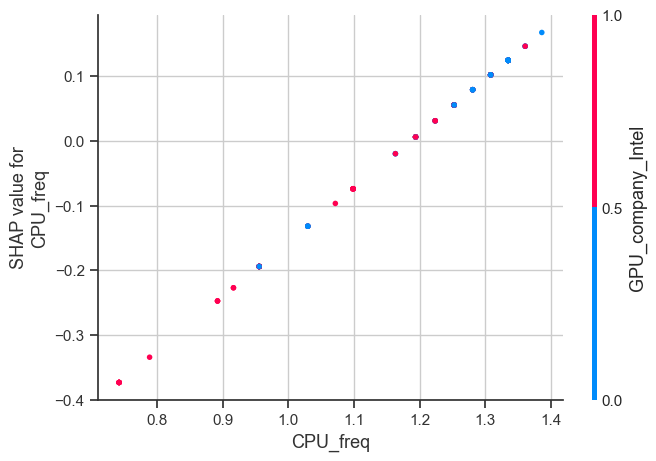

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

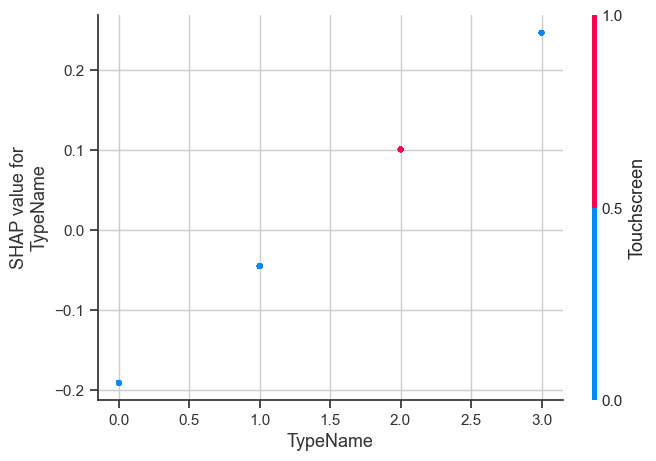

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

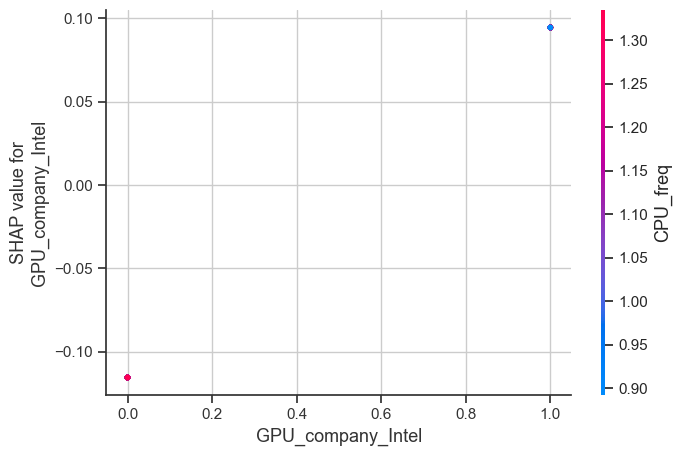

<Figure size 640x480 with 0 Axes>

In [26]:
# Konfiguracja stylu wykresów
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})  # Ustawienie większego rozmiaru czcionki

# 1. Odczyt danych
train_data = pd.read_csv(TRAIN_FILE_PATH)
val_data = pd.read_csv(VAL_FILE_PATH)

# 2. Przygotowanie danych
# Usunięcie wierszy z brakującymi wartościami
train_data = train_data.dropna()
val_data = val_data.dropna()

# Podział na cechy i zmienną docelową
X_train = train_data.drop(columns=['Price_euros'])
y_train = train_data['Price_euros']

X_val = val_data.drop(columns=['Price_euros'])
y_val = val_data['Price_euros']

# Kodowanie cech kategorycznych
# Łączymy dane treningowe i walidacyjne, aby zapewnić spójne kodowanie
X_combined = pd.concat([X_train, X_val], axis=0)
X_combined = pd.get_dummies(X_combined, drop_first=True)

# Rozdzielenie z powrotem na zbiór treningowy i walidacyjny
X_train_encoded = X_combined.iloc[:len(X_train), :].reset_index(drop=True)
X_val_encoded = X_combined.iloc[len(X_train):, :].reset_index(drop=True)

# Wyświetlenie rzeczywistych nazw cech po kodowaniu
# print("\nRzeczywiste nazwy cech po kodowaniu (przykład):")
# print(X_train_encoded.columns.tolist()[:10])  # Wyświetlenie pierwszych 10 cech

# 3. Skalowanie cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# Konwersja przeskalowanych danych z powrotem do DataFrame z nazwami kolumn
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_encoded.columns)

# 4. Trenowanie modelu regresji liniowej
regression_model = LinearRegression()
regression_model.fit(X_train_scaled_df, y_train)

# 5. Walidacja modelu
y_val_pred = regression_model.predict(X_val_scaled_df)
r2_val = r2_score(y_val, y_val_pred)
print("\nWynik R² na zbiorze walidacyjnym:", r2_val)

# 6. Wizualizacja wyników na zbiorze walidacyjnym
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Wykres rzeczywistych vs przewidywanych wartości
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, color='blue', label='Predykcje', ax=axes[0])
axes[0].plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    color='red',
    lw=2,
    label='Idealne dopasowanie'
)
axes[0].set_title("Rzeczywiste vs. Przewidywane wartości")
axes[0].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[0].set_ylabel("Przewidywane wartości (Price_euros)")
axes[0].legend()

# Wykres reszt
residuals_val = y_val - y_val_pred
sns.scatterplot(x=y_val_pred, y=residuals_val, alpha=0.6, color='green', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', lw=2, label="Linia zerowa")
axes[1].set_title("Wykres reszt")
axes[1].set_xlabel("Przewidywane wartości (Price_euros)")
axes[1].set_ylabel("Reszty")
axes[1].legend()

# Histogram błędów (reszt)
sns.histplot(residuals_val, kde=True, bins=30, color='purple', alpha=0.7, ax=axes[2])
axes[2].axvline(0, color='red', linestyle='--', lw=2, label="Linia zerowa")
axes[2].set_title("Histogram błędów (reszt)")
axes[2].set_xlabel("Reszty")
axes[2].set_ylabel("Częstość")
axes[2].legend()

plt.tight_layout()
plt.show()

# 7. Wykorzystanie wartości SHAP do interpretacji modelu

# Tworzenie wyjaśniacza SHAP
explainer = shap.Explainer(regression_model, X_train_scaled_df)
shap_values = explainer(X_val_scaled_df)

# Analiza ważności cech na podstawie współczynników regresji
coefficients = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coefficient': regression_model.coef_
})
coefficients['Sign'] = coefficients['Coefficient'] > 0
coefficients['Sign'] = coefficients['Sign'].astype(str)  # Konwersja do stringów 'True'/'False'

# Sortowanie cech według absolutnej wartości współczynnika
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)

print("\nNajważniejsze cechy wpływające na cenę:")
print(coefficients[['Feature', 'Coefficient']].head(10))

# Wykres barplot z różnymi kolorami dla dodatnich i ujemnych współczynników
plt.figure(figsize=(14, 10))
sns.barplot(
    x='Coefficient',
    y='Feature',
    hue='Sign',
    data=coefficients.head(10),
    dodge=False,
    palette={'True': 'blue', 'False': 'red'}
)
plt.title('Najważniejsze cechy wpływające na cenę (Zbiór Walidacyjny)')
plt.xlabel('Współczynnik regresji')
plt.ylabel('Cechy')
plt.legend(title='Współczynnik pozytywny', loc='best')
plt.tight_layout()
plt.show()

# Tworzenie wykresów zależności SHAP dla top 5 cech
top_features = coefficients['Feature'].head(5).values
for feature in top_features:
    if feature in X_val_encoded.columns:
        plt.figure(figsize=(14, 10))
        shap.dependence_plot(feature, shap_values.values, X_val_encoded)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cecha '{feature}' nie istnieje w danych walidacyjnych.")

# 9. Model klasyfikacji - Wartości Shapleya i interpretacja


Wynik R² na zbiorze testowym: 0.7121513392921521
Mean Absolute Error (MAE) na zbiorze testowym: 0.25335842963590166
Root Mean Squared Error (RMSE) na zbiorze testowym: 0.3239999543931189

Najważniejsze cechy wpływające na cenę:
               Feature  Coefficient
3                  Ram     0.346928
14  GPU_company_Nvidia     0.190164
5             CPU_freq     0.141547
1             TypeName     0.134352
13   GPU_company_Intel     0.104517
11        OS_Windows 7     0.093249
0              Company     0.068324
7            GPU_model     0.058111
8             OS_No OS    -0.056071
10       OS_Windows 10     0.050406


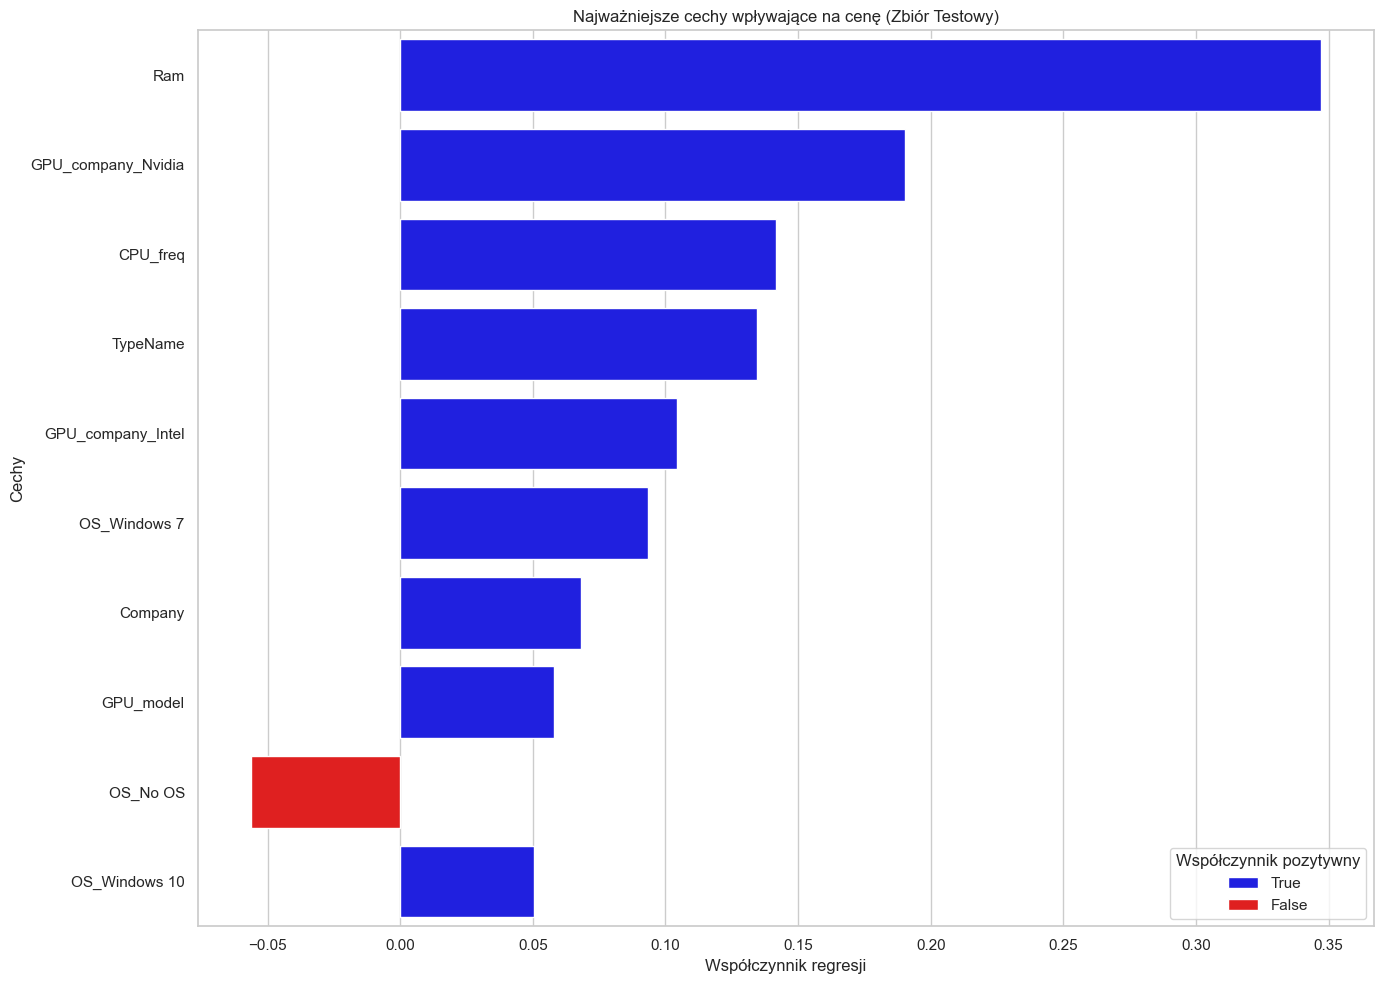

<Figure size 1400x1000 with 0 Axes>

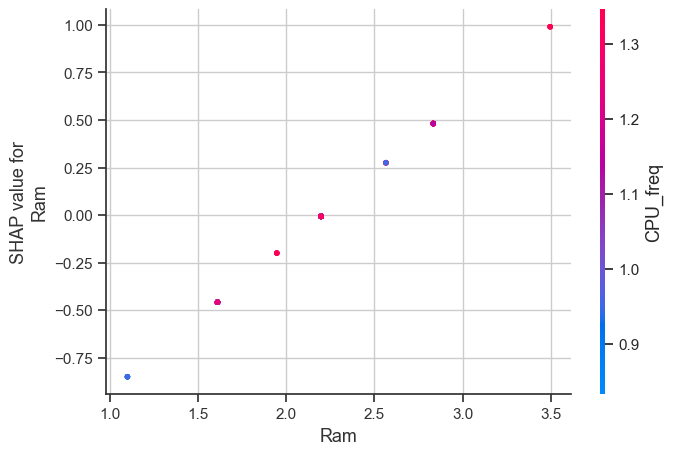

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

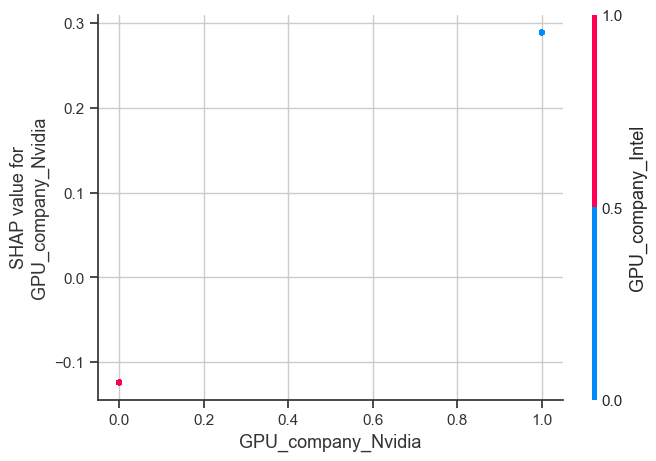

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

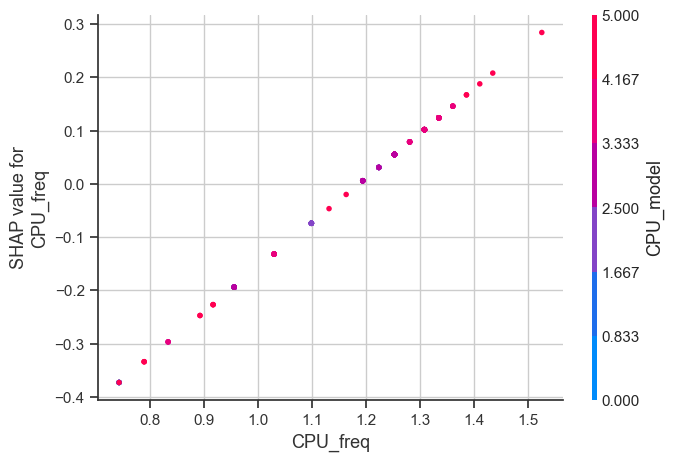

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

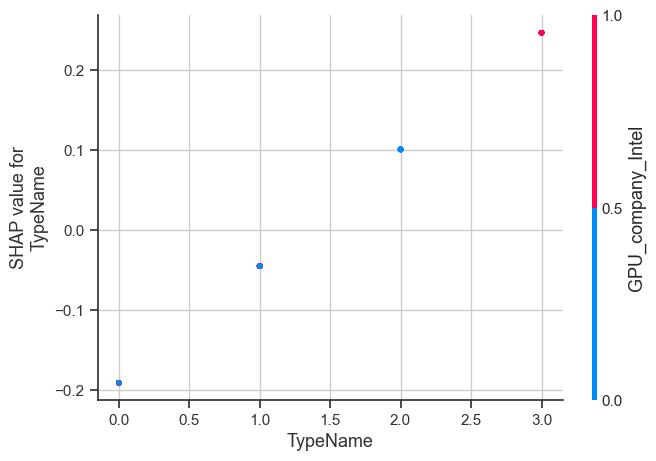

<Figure size 640x480 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

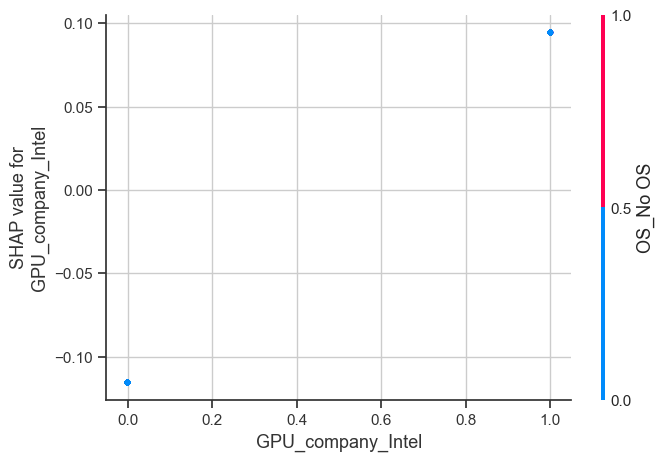

<Figure size 640x480 with 0 Axes>

In [27]:
# Konfiguracja stylu wykresów
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})  # Ustawienie większego rozmiaru czcionki

# 1. Odczyt danych
TEST_FILE_PATH = './test_data.csv'  # Upewnij się, że ścieżka jest poprawna

test_data = pd.read_csv(TEST_FILE_PATH)

# Usunięcie wierszy z brakującymi wartościami
test_data = test_data.dropna()

# Podział na cechy i zmienną docelową
X_test = test_data.drop(columns=['Price_euros'])  # Upewnij się, że nazwa kolumny jest poprawna
y_test = test_data['Price_euros']

# Zakładamy, że `X_train_encoded` i `scaler` są już zdefiniowane w środowisku Jupyter
# Jeśli nie, musisz je ponownie zdefiniować lub uruchomić odpowiednie komórki

# Kodowanie cech kategorycznych w danych testowych
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Dodanie brakujących kolumn w danych testowych, które były obecne w danych treningowych
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

# Upewnienie się, że kolejność kolumn jest taka sama jak w danych treningowych
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Skalowanie danych testowych
X_test_scaled = scaler.transform(X_test_encoded)

# Konwersja przeskalowanych danych z powrotem do DataFrame z nazwami kolumn
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

# 2. Ocena modelu na zbiorze testowym
y_test_pred = regression_model.predict(X_test_scaled_df)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nWynik R² na zbiorze testowym:", r2_test)
print("Mean Absolute Error (MAE) na zbiorze testowym:", mae_test)
print("Root Mean Squared Error (RMSE) na zbiorze testowym:", rmse_test)

# Obliczenie reszt
residuals_test = y_test - y_test_pred

# 3. Wykorzystanie wartości SHAP na zbiorze testowym

# Tworzenie wyjaśniacza SHAP dla danych testowych
explainer_test = shap.Explainer(regression_model, X_train_scaled_df)
shap_values_test = explainer_test(X_test_scaled_df)

# Analiza ważności cech na podstawie współczynników regresji
coefficients_test = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coefficient': regression_model.coef_
})
coefficients_test['Sign'] = coefficients_test['Coefficient'] > 0
coefficients_test['Sign'] = coefficients_test['Sign'].astype(str)  # Konwersja do stringów 'True'/'False'

# Sortowanie cech według absolutnej wartości współczynnika
coefficients_test = coefficients_test.reindex(coefficients_test['Coefficient'].abs().sort_values(ascending=False).index)

print("\nNajważniejsze cechy wpływające na cenę:")
print(coefficients_test[['Feature', 'Coefficient']].head(10))

# Wykres barplot z różnymi kolorami dla dodatnich i ujemnych współczynników
plt.figure(figsize=(14, 10))
sns.barplot(
    x='Coefficient',
    y='Feature',
    hue='Sign',
    data=coefficients_test.head(10),
    dodge=False,
    palette={'True': 'blue', 'False': 'red'}
)
plt.title('Najważniejsze cechy wpływające na cenę (Zbiór Testowy)')
plt.xlabel('Współczynnik regresji')
plt.ylabel('Cechy')
plt.legend(title='Współczynnik pozytywny', loc='best')
plt.tight_layout()
plt.show()

# Tworzenie wykresów zależności SHAP dla top 5 cech w zbiorze testowym
top_features_test = coefficients_test['Feature'].head(5).values
for feature in top_features_test:
    if feature in X_test_encoded.columns:
        plt.figure(figsize=(14, 10))
        shap.dependence_plot(feature, shap_values_test.values, X_test_encoded)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cecha '{feature}' nie istnieje w danych testowych.")
